In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convolution.conv_2d import Conv2D
from pooling.maxpool_2d import MaxPooling2D
from layers.layer_dense import Layer_Dense
from activation_func.relu import Activation_ReLU
from loss.activation_softmax_loss_categorical_crossentropy import Activation_Softmax_Loss_CategoricalCrossentropy
from optimizers.adagrad import Optimizer_Adagrad

In [2]:
#load datasets
test_csv_path='mnist/mnist/test.csv'
train_csv_path='mnist/mnist/train.csv'

In [3]:
#load the dataset
train_data=pd.read_csv(train_csv_path)
test_data=pd.read_csv(test_csv_path)

In [4]:
#split the dataset
y_train = train_data['label'].values
x_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255

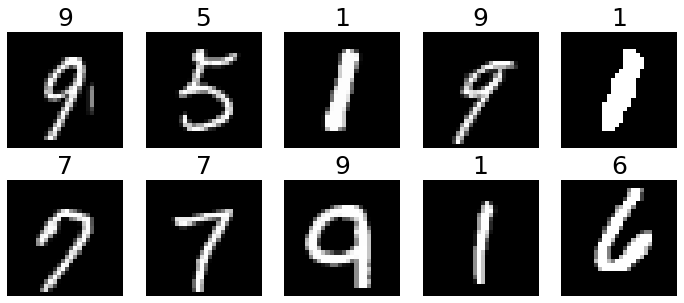

In [5]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()